In [49]:
import xopen
import json
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from urllib.parse import urlparse
import tldextract

def get_dist(s):
    return s.value_counts().pipe(lambda s: s/s.sum())

def source_counts(pre_df, post_df):
    f, ax = plt.subplots(1, 1, figsize=(4,1 ))
    (
        pd.concat([
            (pre_df
                 .groupby('doc_idx')
                 ['is_quote'].mean()
                 .to_frame('%')
                 .assign(split='pre')
            ),
            (
                post_df
                    .groupby('doc_idx')
                    ['is_quote']
                    .mean()
                    .to_frame('%')
                    .assign(split='post')
            )

        ])

        .pipe(lambda df: sns.boxplot(data=df, y='split', x='%', orient='h', ax=ax))
    )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('% of Sentences are Sourced')
    plt.ylabel('')

    f, ax = plt.subplots(1, 1, figsize=(4,1 ))
    (
        pd.concat([
                (pre_df
                     .groupby('doc_idx')['attribution']
                     .aggregate(list)
                     .apply(set).str.len()
                     .pipe(lambda s: s - 1)
                     .to_frame('num sources / doc')
                     .assign(split='pre')
                ),
                (post_df
                     .groupby('doc_idx')['attribution']
                     .aggregate(list)
                     .apply(set).str.len()
                     .pipe(lambda s: s - 1)
                     .to_frame('num sources / doc')
                     .assign(split='post')             
                )
            ])
            .pipe(lambda df: sns.boxplot(data=df, x='num sources / doc', y='split', orient='h', showfliers=False, ax=ax))             
            )

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('# Sources / Document')
    plt.ylabel('')

def generate_quote_type_comparison(pre_df, post_df, pre_df_b=None, post_df_b=None):
    # calculate
    dist_pre = (pre_df['quote_type']
                 .loc[lambda s: s != 'No Quote']
                 .pipe(get_dist)
               )
    dist_post = (post_df['quote_type']
                 .loc[lambda s: s != 'No Quote']
                 .pipe(get_dist)
                )
    
    if (pre_df_b is not None) and (post_df_b is not None):
        dist_pre = dist_pre - (pre_df_b['quote_type'].loc[lambda s: s != 'No Quote'].pipe(get_dist))
        dist_post = dist_post - (post_df_b['quote_type'].loc[lambda s: s != 'No Quote'].pipe(get_dist))        
    
    # plot
    f, ax = plt.subplots(1, 1, figsize=(6, 2 ))
    (pd.concat([
        (dist_pre.to_frame('%').assign(split='pre')),
        (dist_post.to_frame('%').assign(split='post'))
    ])
    .reset_index()
    .pipe(lambda df: sns.barplot(data=df, x='quote_type', y='%', hue='split', ax=ax))
    )
    plt.xticks(rotation=25, horizontalalignment='right');

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylabel('Quote Type Distribution')
    plt.xlabel('')

def generate_source_type_comparisons(pre_df, post_df, pre_df_b=None, post_df_b=None):
    for idx, (col, label) in enumerate([
        ('source_type', 'Source Type Distribution'),
        ('affiliation', 'Affiliation'),
        ('role', 'Role')
    ]):
        # calculate distributions
        dist_pre = pre_df[col].pipe(get_dist)
        dist_post = post_df[col].pipe(get_dist)
        if (pre_df_b is not None) and (post_df_b is not None):
            dist_pre = dist_pre - pre_df_b[col].pipe(get_dist)
            dist_post = dist_post - post_df_b[col].pipe(get_dist)

        # plot
        f, ax = plt.subplots(1, 1, figsize=(6, 2))
        (pd.concat([
                dist_pre.to_frame('%').assign(split='pre'), 
                dist_post.to_frame('%').assign(split='post')
        ])
            .reset_index()
            .pipe(lambda df: sns.barplot(data=df, x=col, y='%', hue='split', ax=ax))
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel(label)
        ax.set_xlabel('')

    plt.tight_layout()

# Chinese Expulsion

# Load Data

In [32]:
orig_df = pd.read_csv('../data/china-annotated/china-news__2019-2021.csv')
orig_df['domain'] = (
    orig_df['url']
        .apply(lambda x: urlparse(x).netloc)
        .apply(lambda x: tldextract.extract(x).domain)
)

/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_62675/3438929915.py:1: DtypeWarning: Columns (0,11) have mixed types. Specify dtype option on import or set low_memory=False.
  orig_df = pd.read_csv('../data/china-annotated/china-news__2019-2021.csv')


In [33]:
# load full news document
news_doc_df = []
with xopen.xopen('../data/china-annotated/china-news-source-annotations__0-0__.jsonl.gz') as f:
    for line in f:
        t = json.loads(line)
        news_doc_df.append(pd.DataFrame(t))
        
full_news_doc_df = pd.concat(news_doc_df)
full_news_doc_df = full_news_doc_df.merge(
    orig_df[['url', 'domain', 'publishedAt']],
    right_on='url',
    left_on='doc_idx', 
).drop(columns=['url'])

In [34]:
# load source document
source_doc_df = []
with xopen.xopen('../data/china-annotated/china-news-source-characteristics.jsonl.gz') as f:
    for line in f:
        t = json.loads(line)
        source_doc_df.append(pd.DataFrame(t))

full_source_doc_df = (
    pd.concat(source_doc_df)
        .loc[lambda df: df['name'].notnull()]
        .rename(columns={'source-type': 'source_type'})
)

full_source_doc_df = full_source_doc_df.merge(
    orig_df[['url', 'domain', 'publishedAt']],
    right_on='url',
    left_on='doc_id', 
).drop(columns=['url'])

# Run Basic Analysis

In [50]:
pre_news_df = full_news_doc_df.loc[lambda df: df['publishedAt'] < '2020-03-01']
post_news_df = full_news_doc_df.loc[lambda df: df['publishedAt'] > '2020-03-01']

pre_source_df = full_source_doc_df.loc[lambda df: df['publishedAt'] < '2020-03-01']
post_source_df = full_source_doc_df.loc[lambda df: df['publishedAt'] > '2020-03-01']

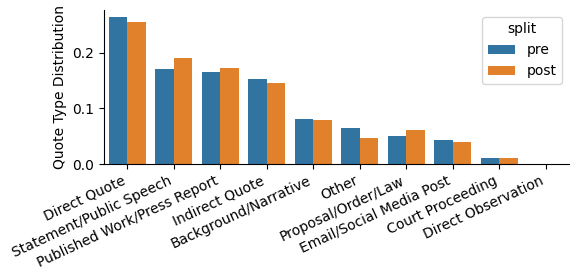

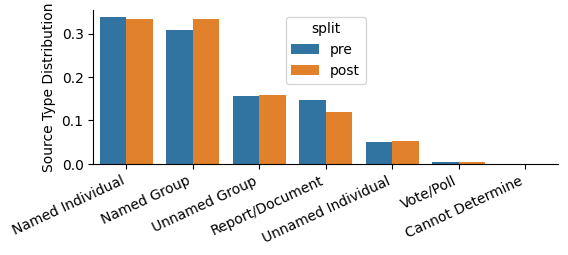

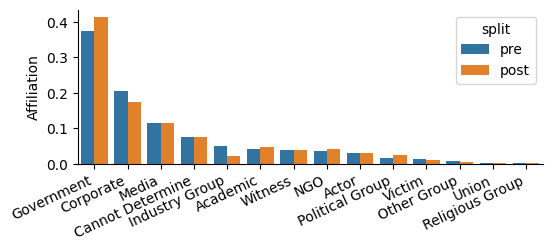

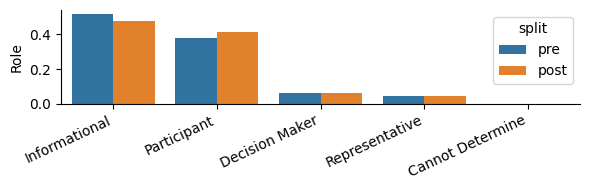

In [51]:
generate_quote_type_comparison(pre_news_df, post_news_df)
generate_source_type_comparisons(pre_source_df, post_source_df)

# Run Analysis just on the ones that were excluded

In [52]:
pre_news_df = (
    full_news_doc_df
        .loc[lambda df: df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] < '2020-03-01']
)
post_news_df = (
    full_news_doc_df
        .loc[lambda df: df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] > '2020-03-01']
)

pre_source_df = (
    full_source_doc_df
        .loc[lambda df: df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] < '2020-03-01']
)
post_source_df = (
    full_source_doc_df
        .loc[lambda df: df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] > '2020-03-01']
)

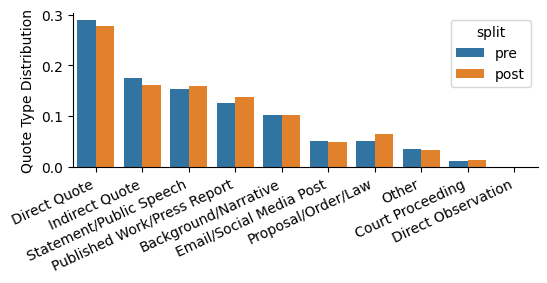

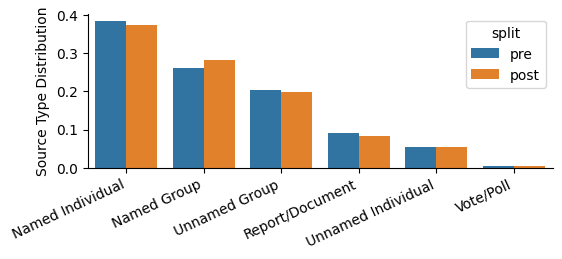

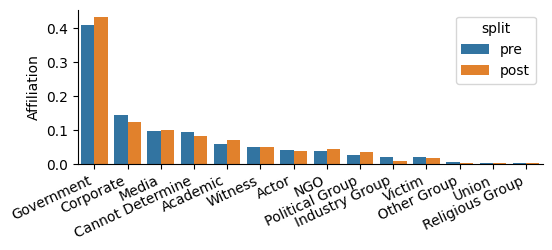

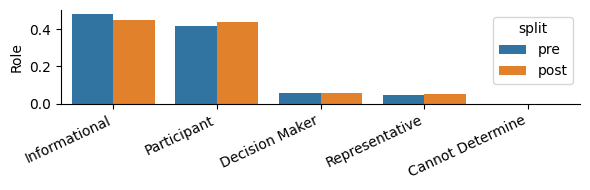

In [53]:
generate_quote_type_comparison(pre_news_df, post_news_df)
generate_source_type_comparisons(pre_source_df, post_source_df)

# Run Comparison Analysis

In [54]:
pre_news_df_a = (
    full_news_doc_df
        .loc[lambda df: df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] < '2020-03-01']
)
post_news_df_a = (
    full_news_doc_df
        .loc[lambda df: df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] > '2020-03-01']
)

pre_source_df_a = (
    full_source_doc_df
        .loc[lambda df: df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] < '2020-03-01']
)
post_source_df_a = (
    full_source_doc_df
        .loc[lambda df: df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] > '2020-03-01']
)

pre_news_df_b = (
    full_news_doc_df
        .loc[lambda df: ~df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] < '2020-03-01']
)
post_news_df_b = (
    full_news_doc_df
        .loc[lambda df: ~df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] > '2020-03-01']
)

pre_source_df_b = (
    full_source_doc_df
        .loc[lambda df: ~df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] < '2020-03-01']
)
post_source_df_b = (
    full_source_doc_df
        .loc[lambda df: ~df['domain'].isin(['nytimes', 'wsj', 'washingtonpost'])]
        .loc[lambda df: df['publishedAt'] > '2020-03-01']
)

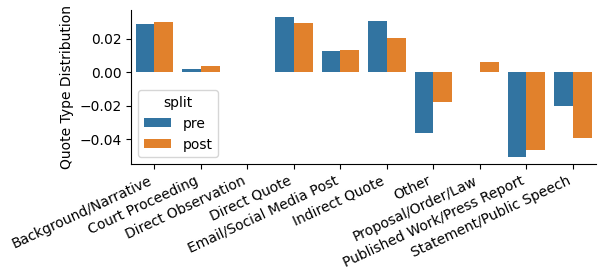

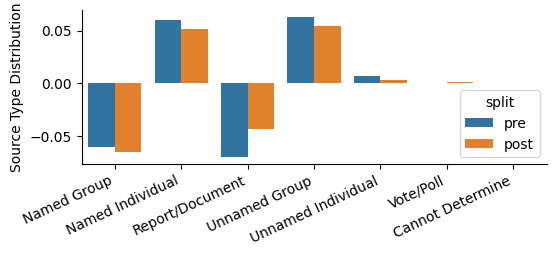

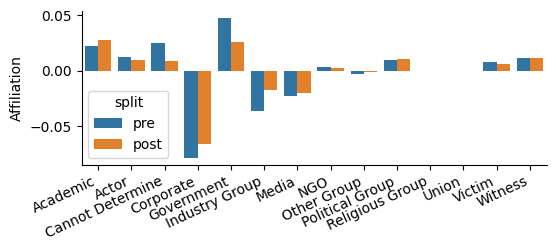

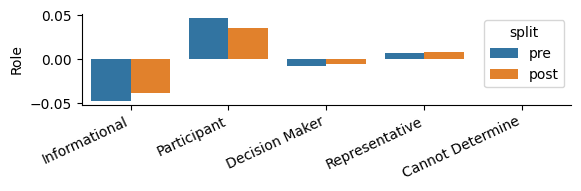

In [55]:
generate_quote_type_comparison(pre_news_df_a, post_news_df_a, pre_news_df_b, post_news_df_b)
generate_source_type_comparisons(pre_source_df_a, post_source_df_a, pre_source_df_b, post_source_df_b)

# New York Times Anonymous Sources

In [1]:
import requests
from tqdm.auto import tqdm
from time import sleep
import pandas as pd 

In [2]:
import datetime

In [6]:
today = datetime.datetime.today()

In [8]:
datetime.datetime(2023, 10, 1) < today

True

In [10]:
api_key = 'U2s1XY2fFGSA8LPqhr4egrhnuws1VGdv'
all_results = []
for year in tqdm([2021, 2022, 2023, ]):
    for month in tqdm(range(1, 13)):
        if datetime.datetime(year, month, 1) < today:
            search_api = f'https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api_key}'
            res = requests.get(search_api)
            results = res.json()
            all_results.append(results)
            sleep(12)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [11]:
all_docs = []
for month_res in all_results:
    all_docs += month_res['response']['docs']

In [12]:
all_docs_df = pd.DataFrame(all_docs)

In [14]:
# mkdir ../data/2014-2018__anonymous-sources
! mkdir ../data/2021-2023__current-articles

In [15]:
all_docs_df.to_csv('../data/2021-2023__current-articles/nytimes-article-metadata.csv')

In [16]:
all_docs_df[['web_url', 'pub_date']].to_csv('../data/2021-2023__current-articles/nytimes-urls-to-get.csv')

# Source Anonymity

In [19]:
announcement_of_anonymous_policy_shift = 'https://archive.nytimes.com/publiceditor.blogs.nytimes.com/2016/03/15/new-york-times-anoymous-sources-policy-public-editor/'

# News Edits

In [51]:
import sqlite3

article_con = sqlite3.connect('../data/news-edits/newssniffer-nytimes.db')
matched_sents_con = sqlite3.connect('../data/news-edits/nyt-matched-sentences.db')

In [46]:
show_tables_sql = """SELECT name FROM sqlite_master  
  WHERE type='table';"""

In [47]:
pd.read_sql(show_tables_sql, con=article_con)

,name
0,entryversion


In [52]:
pd.read_sql(show_tables_sql, con=matched_sents_con)

,name
0,matched_sentences
1,split_sentences
2,doc_level_stats


In [49]:
pd.read_sql("SELECT * from entryversion limit 2", con=article_con)

,index,version,title,created,url,source,entry_id,archive_url,num_versions,summary,joint_key,id
0,68763,0,Activist Challenges a Sweeping Revision in Pat...,2012-08-26 22:55:00+00:00,http://www.nytimes.com/2012/08/27/technology/m...,nytimes,547988,https://www.newssniffer.co.uk/articles/547988/...,2,"In Silicon Valley, Apple just won big against ...",547988-0,547988-0
1,68764,1,Inventor Challenges a Sweeping Revision in Pat...,2012-08-27 02:55:00+00:00,http://www.nytimes.com/2012/08/27/technology/m...,nytimes,547988,https://www.newssniffer.co.uk/articles/547988/...,2,"In Silicon Valley, Apple just won big against ...",547988-1,547988-1


In [54]:
all_doc_level_stats_df = pd.read_sql("SELECT * from doc_level_stats", con=matched_sents_con)

In [55]:
## get articles with many versions and a substantial # of additions from 1st version to last

In [130]:
entry_ids_to_fetch = (all_doc_level_stats_df
     .loc[lambda df: (df['num_added'] / df['num_unchanged']) > .1]
     .loc[lambda df: (df['num_deleted'] / df['num_added']) < .5]
)['entry_id']
filter_str = ', '.join(list(map(str, entry_ids_to_fetch)))

In [132]:
article_text_to_score = pd.read_sql(f"SELECT * from entryversion where entry_id in ({filter_str}) ", con=article_con)

In [138]:
article_text_to_score = article_text_to_score.drop_duplicates('summary')

In [140]:
article_text_to_score.to_csv('../data/news-edits/article-text-to-score.csv.gz')

In [166]:
article_text_to_score.shape[0]

140569

In [147]:
t= article_text_to_score.loc[lambda df: df['id'] == '1916702-12']['summary'].iloc[0]

In [150]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [152]:
s = list(nlp(t.replace('</p><p>', ' ')).sents)

In [157]:
s[25]

Both the governor and the mayor seemed resistant to closing schools, with Mr. Cuomo citing the resilience of most children to the virus.

# Visualize

In [123]:
html = make_html_wrapper(entry_id=548087, version_pair=2, matching_sent_con=matched_sents_con)
with open('test-html.html', 'w') as f:
    f.write(html)

! open test-html.html

In [118]:
import sys
sys.path.insert(0, '../../news-edits-public/')
import util.util_data_fetching_for_app as uda
from jinja2 import Template, Environment, FileSystemLoader
import datetime
from IPython.display import display, HTML

def make_html_wrapper(entry_id, version_pair, matching_sent_con):    
    # 1. set up the Jinja environment and select the template we will write to
    jinja_env = Environment(loader=FileSystemLoader('../../news-edits-public/evaluation/templates'))
    template = jinja_env.get_template('visualize-doc-level-edits.html')
    
    # 2. select one target article and do some processing
    one_article_matched_df = pd.read_sql(f'''
        SELECT * FROM matched_sentences 
        WHERE entry_id = {entry_id}
    ''', con=matching_sent_con).assign(source='nyt')
    
    one_article_sentences_df = (
        pd.read_sql(f'''SELECT * from split_sentences where entry_id = {entry_id}''', con=matching_sent_con)
            .assign(source='nyt')
    )
    
    data_to_render = uda.match_sentences(one_article_matched_df, one_article_sentences_df)
    data_dict_for_rendering = uda.dump_output_to_app_readable(data_to_render)
    num_version_pairs = len(data_dict_for_rendering.keys())
    if version_pair > num_version_pairs:
        raise Exception(f"Please specify a version_pair < {num_version_pairs} for entry_id {entry_id}")
    
    one_key = list(data_dict_for_rendering.keys())[version_pair]
    one_doc_to_render = data_dict_for_rendering[one_key]
    
    # 3. write to the template, generating a full HTML file, and write this to disk
    html = template.render(
        data=one_doc_to_render,
        doc_id=one_key,
        do_mturk=False,
        start_time=str(datetime.datetime.now()),
    )
    return html